In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# load data

In [3]:
fault_label = {
    '0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

X = []
y = []

print("Opening dataset...")
try:
    with open("data_msg_type/x.txt", 'rU') as f:
        res = list(f)
        for line in res:
            line.strip("\n")
            features = line.split("\t")
            while features.__contains__(""):
                features.remove("")
            for i in range(len(features)):
                features[i] = float(features[i])
            X.append(features)
         
    #read the classes from file and put them in list.      
    with open("data_msg_type/y.txt", 'rU') as f:
        res = list(f)
        for line in res:
            y.append(int(line.strip("\n")[0]))
            
except:
    print("Error in reading the train set file.")
    exit()

print("Dataset loaded.")

Opening dataset...
Dataset loaded.


# split data

In [4]:
X = np.array(X) #change to matrix
y = np.array(y) #change to matrix (sklearn models only accept matrices)

print("Separating data into 80% training set & 20% test set...")
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.20, random_state=33)#random split.
print("Dataset separated.\n")

Separating data into 80% training set & 20% test set...
Dataset separated.



# random forest train

In [5]:
print("---------------Random Forest---------------")
n_estimators_list = range(1, 11) #try from one to 21 estimators.
result_random_forests = [] #to be used later for comparing rf with different estimators.
max_score_rf = float("-inf") #just in case we get NaN
best_param_rf = None

for trees in n_estimators_list:
    print("Testing %d trees" % trees)
    rf_clf = RandomForestClassifier(
        n_estimators=trees, max_depth=None, min_samples_split=2, random_state=0)
    scores = cross_validation.cross_val_score(
        rf_clf, X_train, y_train, scoring="accuracy", cv=14)
    result_random_forests.append(scores.mean())
    if scores.mean() > max_score_rf:
        max_score_rf = scores.mean()
        best_param_rf = {"n_estimators": trees}

---------------Random Forest---------------
Testing 1 trees


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=14.
  % (min_labels, self.n_folds)), Warning)


Testing 2 trees
Testing 3 trees
Testing 4 trees
Testing 5 trees
Testing 6 trees
Testing 7 trees
Testing 8 trees
Testing 9 trees
Testing 10 trees


# test and predict

In [6]:
rf_clf = RandomForestClassifier(n_estimators=best_param_rf.get("n_estimators"), 
                    max_depth=None, min_samples_split=2, random_state=0).fit(X_train, y_train)

rf_clf_test_score = rf_clf.score(X_test, y_test)

# save trained model for future use.
#joblib.dump(rf_clf,'data/rf_clf.pkl', compress=9)

count1 = 0
count2 = 0
actualist = []
predlist = []

for i in range(len(X_test)):
    count2 += 1
    classinrow = X_test[i]
    classinrow = np.array(X_test[i]).reshape(1,-1)
    # each xval is a set of features la one sample.
    # predict class for each row.. each i is a row.
    predicted = rf_clf.predict(classinrow)
    actual = y_test[i]
    actualist.append(actual)
    predlist.append(predicted[0])
    if predicted == actual:
        count1 += 1
print()
print("Number of trees in forest: ", len(n_estimators_list))
print("Results: ", result_random_forests)
print("Best accuracy: ", max_score_rf)
print("Best parameter: ", best_param_rf)
print("Test set accuracy: ", rf_clf_test_score)

print("Total cases: ", count2)
print("Correct Prediction: ", count1)
print("Correct prediction rate: ", float(count1) / count2)

()
('Number of trees in forest: ', 10)
('Results: ', [0.99998125124911919, 0.99998125398352855, 0.99997500531137129, 0.99998125398352855, 0.9999875026556857, 0.99998125398352855, 0.99999375132784274, 0.9999875026556857, 0.9999875026556857, 0.9999875026556857])
('Best accuracy: ', 0.99999375132784274)
('Best parameter: ', {'n_estimators': 7})
('Test set accuracy: ', 0.99997499999999995)
('Total cases: ', 40000)
('Correct Prediction: ', 39999)
('Correct prediction rate: ', 0.999975)


# plot

               precision    recall  f1-score   support

     security       1.00      1.00      1.00       279
       others       1.00      1.00      1.00      3115
    processor       1.00      1.00      1.00      5774
         disk       1.00      1.00      1.00        16
      network       1.00      1.00      1.00       248
         file       1.00      1.00      1.00     29818
     database       1.00      1.00      1.00        64
      service       1.00      1.00      1.00       479
       memory       1.00      1.00      1.00       207

  avg / total       1.00      1.00      1.00     40000

[[  279     0     0     0     0     0     0     0     0]
 [    0  3115     0     0     0     0     0     0     0]
 [    0     0  5774     0     0     0     0     0     0]
 [    0     0     0    16     0     0     0     0     0]
 [    0     0     0     0   248     0     0     0     0]
 [    0     0     0     0     0 29818     0     0     0]
 [    0     0     0     0     0     0    64     0 

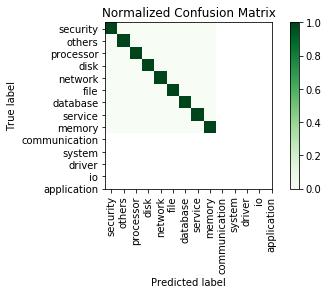

In [7]:
# cmap can be changed to many colors, (colormaps.Oranges,OrRd, etc)
def plot_CM(cm, title="Normalized Confusion Matrix", cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=90)
    plt.yticks(tick_marks, fault_label.values())
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

print(metrics.classification_report(
    actualist, predlist, target_names = list(fault_label.values())))
cm = metrics.confusion_matrix(actualist, predlist)
print(cm)

# show a normalized matrix as a separate figure.
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
plt.figure()
plot_CM(cm_normalized)